In [1]:
import math
import numpy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import cycle
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import datetime
import sys
import joblib
import warnings
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_selection import RFE
from mlxtend.feature_selection import SequentialFeatureSelector as Sfs
from sklearn.feature_selection import chi2
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectKBest
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from dateutil.relativedelta import relativedelta
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
from collections import Counter
import plotly.express as px

In [2]:
sns.set()

In [3]:
# Data Import and overview
DATASET_PATH = "../../data/tweets_2020_2021_v2.csv"
df = pd.read_csv(filepath_or_buffer=DATASET_PATH, sep=",")
df = df.sort_values(by='timestamp', ascending=True)
df.tail()

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,index,tweet_id,text,timestamp,user_id,like_count,retweet_count,...,day_phase,week_idx,day_phase_enc,day_of_week_enc,month_enc,year_enc,sentiment_enc,verified_enc,seniority,topics_cleaned
612261,612261,612261,612261,612261,1477036834261770241,…. them crawfish was so good yall lmfao,2021-12-31 21:59:57+00:00,795707439219884037,0,0,...,Night,2021-52,4,0,2,1,2,0,5,NaN
98252,98252,98252,98252,98252,1477036835603836932,Damn all the freaks are at the New Bev right n...,2021-12-31 21:59:58+00:00,34679503,26,0,...,Night,2021-52,4,0,2,1,1,0,13,NaN
1072384,1072384,1072384,1072384,1072384,1477036838217035777,Fast And Professional Vehicle Lockout Service ...,2021-12-31 21:59:58+00:00,210241982,0,0,...,Night,2021-52,4,0,2,1,0,0,11,NaN
1072385,1072385,1072385,1072385,1072385,1477036840024567809,Very much this https://t.co/b3bgtstLfr,2021-12-31 21:59:59+00:00,883576549,3,0,...,Night,2021-52,4,0,2,1,1,0,9,NaN
1072386,1072386,1072386,1072386,1072386,1477036841933185025,Best thread ever https://t.co/EBo4JkTCx4,2021-12-31 21:59:59+00:00,131371694,0,0,...,Night,2021-52,4,0,2,1,2,0,12,NaN


In [4]:
vars = ['like_count', 'retweet_count', 'quote_count', 'reply_count', 'reach', 'topics_ids', 'sentiment_enc', 'day_phase_enc', 'day_of_week_enc', 'month_enc', 'popularity', 'followers', 'following', 'tweet_count', 'verified_enc', 'seniority']
tweet_vars = ['like_count', 'retweet_count', 'quote_count', 'reply_count', 'reach', 'sentiment_enc', 'day_phase_enc', 'day_of_week_enc', 'month_enc']
users_vars = ['followers', 'following', 'tweet_count', 'verified_enc', 'seniority']
num_vars = ['like_count', 'retweet_count', 'quote_count', 'reply_count', 'reach', 'followers', 'following', 'tweet_count', 'seniority']
cat_vars = ['sentiment_enc', 'verified_enc', 'day_of_week_enc', 'day_phase_enc', 'month_enc']

## Spliting the data by year

In [5]:
df_2020 = df[df['year'] == 2020]
df_2021 = df[df['year'] == 2021]

In [6]:
df_2020.shape

(534942, 35)

In [7]:
df_2021.shape

(537445, 35)

# Machine Learning

### Predicting tweet popularity in 2021 using 2020 data with topics

## Data spliting

In [8]:
num_folds = 7
seed = 7
scoring = 'accuracy'
validation_size = 0.70

In [10]:
df_2020_topics = df_2020[(~df_2020['topics'].isnull()) & (df_2020['topics'] != '')]
df_2020_topics

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,index,tweet_id,text,timestamp,user_id,like_count,retweet_count,...,day_phase,week_idx,day_phase_enc,day_of_week_enc,month_enc,year_enc,sentiment_enc,verified_enc,seniority,topics_cleaned
44,44,44,44,44,1212176426587303936,New Year’s Eve was created by the sun to sell ...,2020-01-01 00:59:15,735991364635217921,10,0,...,Dawn,2020-01,1,6,4,0,2,0,5,Holiday
46,46,46,46,46,1212176422896193537,"Looking at all 0 replies to my very sad ""who's...",2020-01-01 00:59:15,857462622920339456,3,0,...,Dawn,2020-01,1,6,4,0,0,0,4,Brand
35,35,35,35,35,1212176423189909506,and he still cheating https://t.co/zYAQ8wc6Vg,2020-01-01 00:59:15,3322006549,2,1,...,Dawn,2020-01,1,6,4,0,0,0,6,Person
41,41,41,41,41,1212176426088181760,Disgruntled Pope Francis pulls himself free fr...,2020-01-01 00:59:15,858762062,0,0,...,Dawn,2020-01,1,6,4,0,2,0,9,Person
52,52,52,52,52,1212176427845607426,My NASA engineer sister..... I would tell you ...,2020-01-01 00:59:16,1057480999943032832,11,0,...,Dawn,2020-01,1,6,4,0,2,0,3,Brand
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154051,154051,154051,154051,154051,1344765260260020224,"This might be more devastating than ""n****r na...",2020-12-31 21:59:57+00:00,206374653,1,0,...,Night,2020-53,4,4,2,0,0,0,11,Brand
679919,679919,679919,679919,679919,1344765260151066624,2020 YOURE a real son of a bitch https://t.co/...,2020-12-31 21:59:57+00:00,387676464,2,1,...,Night,2020-53,4,4,2,0,0,0,10,Music
736687,736687,736687,736687,736687,1344765262147575808,Happy New Year from FreeBikes4KidzMN! Everyone...,2020-12-31 21:59:57+00:00,193418595,2,2,...,Night,2020-53,4,4,2,0,2,0,11,Holiday
803046,803046,803046,803046,803046,1344765266530590722,Wanna give a shoutout to whom ever invented co...,2020-12-31 21:59:58+00:00,988833535,0,0,...,Night,2020-53,4,4,2,0,2,0,9,Interest and Hobbies


In [11]:
inputs = df_2020_topics[tweet_vars + users_vars]
inputs.columns

Index(['like_count', 'retweet_count', 'quote_count', 'reply_count', 'reach',
       'sentiment_enc', 'day_phase_enc', 'day_of_week_enc', 'month_enc',
       'followers', 'following', 'tweet_count', 'verified_enc', 'seniority'],
      dtype='object')

In [16]:
targets = df_2020_topics['popularity']
X_train, X_validation, y_train, y_validation = train_test_split(inputs, targets, test_size=validation_size, random_state=seed, stratify=inputs['month_enc'])
X_train

,like_count,retweet_count,quote_count,reply_count,reach,sentiment_enc,day_phase_enc,day_of_week_enc,month_enc,followers,following,tweet_count,verified_enc,seniority
719930,4,1,0,1,546,0,3,5,10,546,475,31686,0,8
766550,0,0,0,0,646,1,2,5,2,646,636,2485,0,10
773460,0,0,0,0,436,1,2,4,2,436,524,94858,0,11
156962,6,7,3,1,38442,0,4,3,3,20586,22461,87239,0,5
605082,11,0,2,0,2562,1,2,5,5,2562,2723,2420,0,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141077,0,0,0,0,454,0,0,2,10,454,795,52812,0,13
554015,0,0,0,0,2878,0,2,0,1,2878,3431,28246,0,12
322487,0,0,0,0,926,1,4,3,8,926,906,16788,0,9
432611,0,0,1,0,2495,0,0,3,8,2495,1601,171741,0,12


#### Partition of numeric and categorical datasets

In [17]:
X_train_num = X_train[num_vars].set_index(X_train.index)
X_train_cat = X_train[cat_vars].set_index(X_train.index)

X_val_num = X_validation[num_vars].set_index(X_validation.index)
X_val_cat = X_validation[cat_vars].set_index(X_validation.index)

## Standardization

In [18]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled , columns = X_train.columns)

X_val_scaled = scaler.fit_transform(X_validation)
X_val_scaled = pd.DataFrame(X_val_scaled , columns = X_validation.columns)

In [19]:
scaler = StandardScaler().fit(X_train_num)
X_train_num_scaled = scaler.transform(X_train_num)
X_train_num_scaled = pd.DataFrame(X_train_num_scaled, columns = X_train_num.columns).set_index(X_train.index)

X_val_num_scaled = scaler.transform(X_val_num)
X_val_num_scaled = pd.DataFrame(X_val_num_scaled, columns = X_val_num.columns).set_index(X_validation.index)

## Feature Selection

### Univariate variables

In [181]:
X_train_num_scaled.var()

like_count       1.000017
retweet_count    1.000017
quote_count      1.000017
reply_count      1.000017
reach            1.000017
followers        1.000017
following        1.000017
tweet_count      1.000017
seniority        1.000017
dtype: float64

In [182]:
num_feat_to_keep = pd.DataFrame(index=X_train_num_scaled.columns)
num_feat_to_keep

""
like_count
retweet_count
quote_count
reply_count
reach
followers
following
tweet_count
seniority


### Recursive Feature Elimination - RFE

In [183]:
#no of features
nof_list = np.arange(1, 9)
high_score = 0
#Variable to store the optimum features
nof = 0
score_list = []
for n in range(len(nof_list)):
    model = LogisticRegression()
    rfe = RFE(estimator=model, n_features_to_select=nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train_num_scaled, y_train)
    X_val_rfe = rfe.transform(X_val_num_scaled)
    model.fit(X_train_rfe, y_train)

    score = model.score(X_val_rfe, y_validation)
    score_list.append(score)

    if score > high_score:
        high_score = score
        nof = nof_list[n]
print("Optimum number of features: %d" % nof)
print("Score with %d features: %f" % (nof, high_score))

/Users/migueloliveira/opt/anaconda3/envs/pythonProject2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/Users/migueloliveira/opt/anaconda3/envs/pythonProject2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modul

Optimum number of features: 8
Score with 8 features: 0.927166


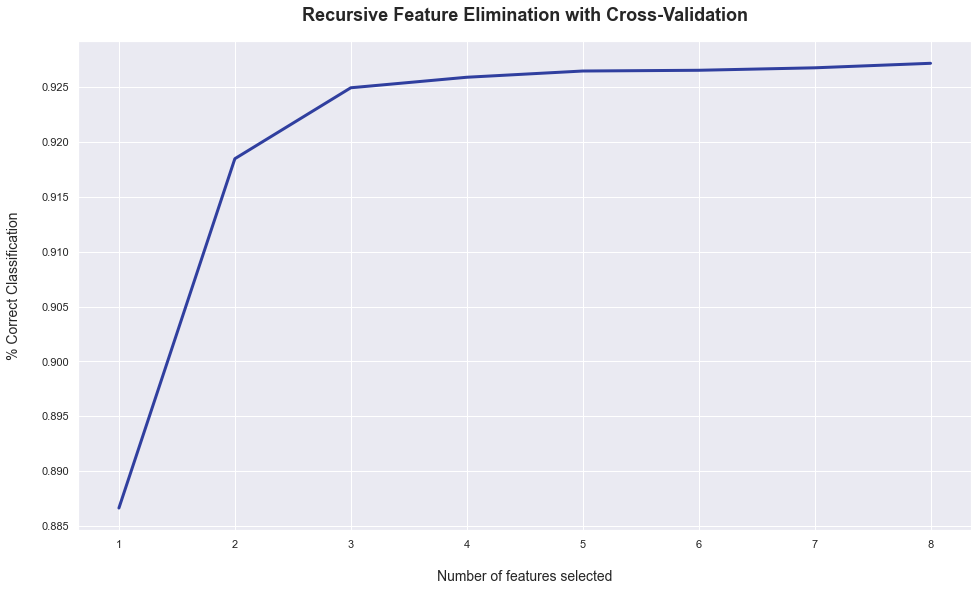

In [184]:
plt.figure(figsize=(16, 9))
plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
plt.ylabel('% Correct Classification', fontsize=14, labelpad=20)
plt.plot(range(1, len(score_list) + 1), score_list, color='#303F9F', linewidth=3)
plt.show()

In [185]:
model = LogisticRegression()
rfe = RFE(estimator=model, n_features_to_select=5)
X_rfe = rfe.fit_transform(X=X_train_num_scaled, y=y_train)
selected_features = pd.Series(rfe.support_, index=X_train_num_scaled.columns)
selected_features[selected_features == True]

/Users/migueloliveira/opt/anaconda3/envs/pythonProject2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



like_count       True
retweet_count    True
quote_count      True
reach            True
followers        True
dtype: bool

In [186]:
num_feat_to_keep['RFE'] = 'Discard'

for var in selected_features[selected_features == True].index:
    num_feat_to_keep.loc[var, 'RFE'] = 'Keep'

### LASSO Regression

In [187]:
def plot_importance(coef, name):
    imp_coef = coef.sort_values()
    plt.figure(figsize=(8, 10))
    imp_coef.plot(kind="barh")
    plt.title("Feature importance using " + name + " Model")
    plt.show()

In [188]:
reg = LassoCV()
reg.fit(X_train_num_scaled, y_train)
coef = pd.Series(reg.coef_,
                 index=X_train_num_scaled.columns)  #Check the coefficients associated with each of the variables
coef

like_count       0.000000
retweet_count    0.000000
quote_count      0.013782
reply_count      0.002309
reach            0.016562
followers        0.000000
following        0.012546
tweet_count      0.000000
seniority       -0.000000
dtype: float64

In [189]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " + str(sum(coef == 0)) + " variables")

Lasso picked 4 variables and eliminated the other 5 variables


In [190]:
coef.sort_values()

like_count       0.000000
retweet_count    0.000000
followers        0.000000
tweet_count      0.000000
seniority       -0.000000
reply_count      0.002309
following        0.012546
quote_count      0.013782
reach            0.016562
dtype: float64

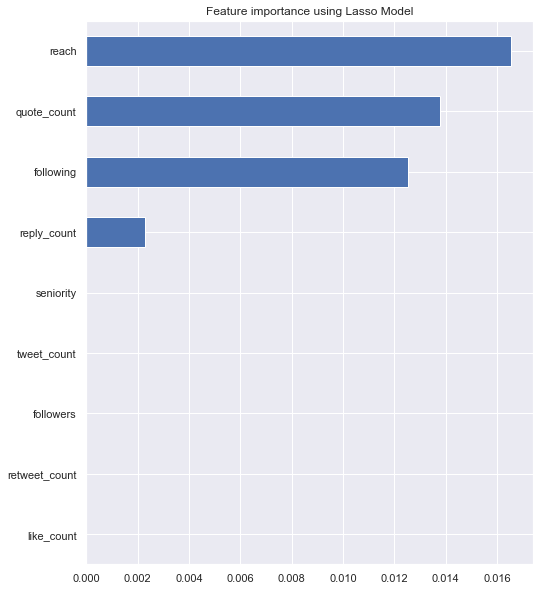

In [191]:
plot_importance(coef,'Lasso')

### Chi-square

In [192]:
chi_scores = chi2(X_train[cat_vars], y_train)
chi_scores

(array([  29.12438373, 2159.55202407,    2.4548875 ,   13.54201155,
          14.39477056]),
 array([6.78772914e-08, 0.00000000e+00, 1.17159562e-01, 2.33282231e-04,
        1.48213338e-04]))

<AxesSubplot:>

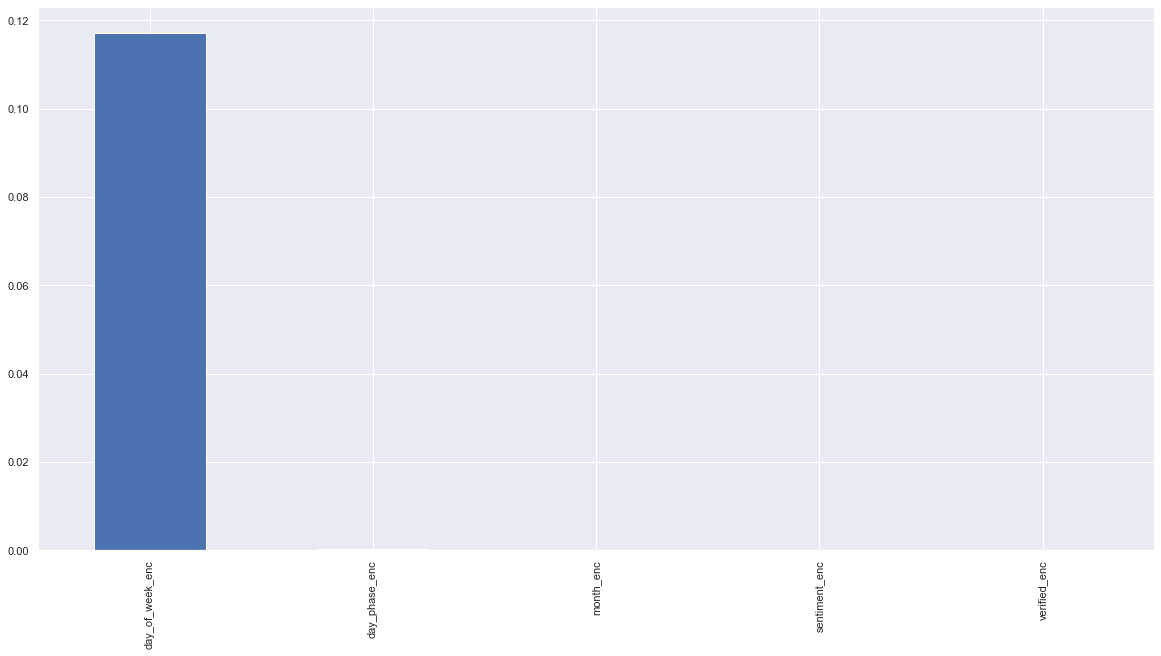

In [193]:
p_values = pd.Series(chi_scores[1], index=cat_vars)
p_values.sort_values(ascending=False, inplace=True)
plt.figure(figsize=(20, 10))
p_values.plot.bar()

In [194]:
chi2_features = SelectKBest(chi2, k=5)
best_features = chi2_features.fit_transform(X_train[cat_vars], y_train)
cols = chi2_features.get_support(indices=True)
cols

array([0, 1, 2, 3, 4])

In [195]:
features_to_keep = X_train[cat_vars].iloc[:, cols]
features_to_keep.columns

Index(['sentiment_enc', 'verified_enc', 'day_of_week_enc', 'day_phase_enc',
       'month_enc'],
      dtype='object')

In [196]:
features_to_keep

,sentiment_enc,verified_enc,day_of_week_enc,day_phase_enc,month_enc
44,2,0,6,1,4
46,0,0,6,1,4
35,0,0,6,1,4
41,2,0,6,1,4
52,2,0,6,1,4
...,...,...,...,...,...
420599,2,0,2,0,0
183184,2,0,2,0,0
54770,2,0,2,0,0
418613,0,0,2,0,0


In [197]:
cat_feat_to_keep = pd.DataFrame(index=cat_vars)
cat_feat_to_keep

""
sentiment_enc
verified_enc
day_of_week_enc
day_phase_enc
month_enc


In [198]:
cat_feat_to_keep['Chi square'] = 'Discard'
cat_feat_to_keep.loc[['sentiment_enc', 'verified_enc', 'day_phase_enc', 'month_enc'],'Chi square']='Keep'

### Ridge regression

In [199]:
ridge = RidgeCV()
ridge.fit(X_train_num_scaled, y_train)
print("Best score using built-in RidgeCV: %f" % ridge.score(X_train_num_scaled, y_train))

Best score using built-in RidgeCV: 0.020590


In [200]:
coef_ridge = pd.Series(ridge.coef_, index=X_train_num_scaled.columns)
coef_ridge.sort_values().head()

seniority       -0.016660
like_count      -0.014145
retweet_count    0.006109
followers        0.007367
tweet_count      0.007875
dtype: float64

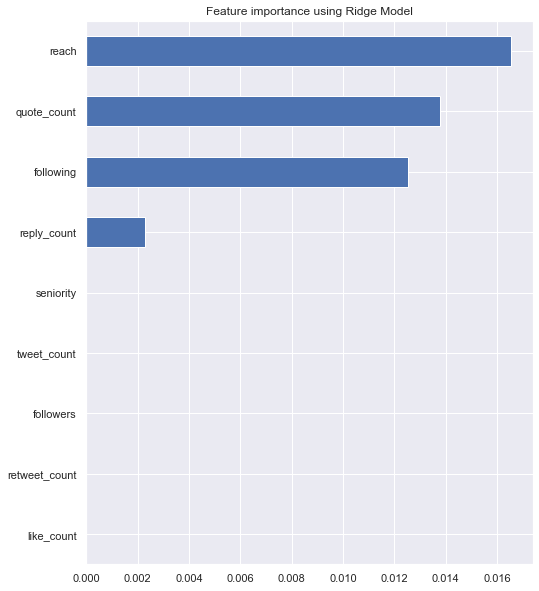

In [201]:
plot_importance(coef, 'Ridge')

In [202]:
num_feat_to_keep['Ridge Regression'] = 'Discard'

for var in abs(coef_ridge).nlargest(5).index:
  num_feat_to_keep.loc[var,'Ridge Regression'] = 'Keep'

### ANOVA

In [203]:
# Select features with best ANOVA F-Values
fvalue_selector = SelectKBest(f_classif, k='all')
X_kbest = fvalue_selector.fit_transform(X_train_num_scaled, y_train)
print('Original number of features:', X_train_num_scaled.shape[1])
print('Reduced number of features:', X_kbest.shape[1])

Original number of features: 9
Reduced number of features: 9


In [204]:
cols = fvalue_selector.get_support(indices=True)
features_to_keep = X_train_num_scaled.iloc[:, cols]
features_to_keep.columns

Index(['like_count', 'retweet_count', 'quote_count', 'reply_count', 'reach',
       'followers', 'following', 'tweet_count', 'seniority'],
      dtype='object')

<AxesSubplot:>

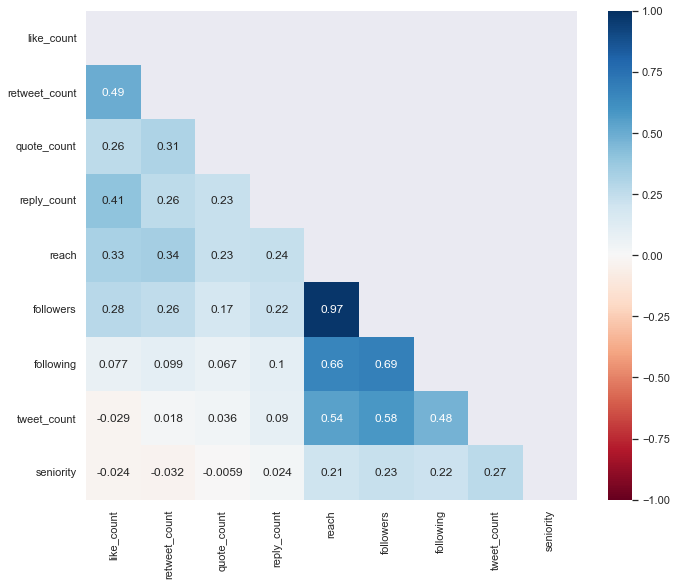

In [205]:
f, ax = plt.subplots(figsize=(11, 9))
mask = np.triu(np.ones_like(X_train_num_scaled.corr(method="spearman"), dtype=bool))
sns.heatmap(X_train_num_scaled.corr(method="spearman"), annot=True, mask=mask, vmin=-1, vmax=1, cmap='RdBu')

In [206]:
num_feat_to_keep['ANOVA'] = 'Discard'

for var in features_to_keep.columns:
    num_feat_to_keep.loc[var, 'ANOVA'] = 'Keep'

### Tree-Based Classifiers

[0.07497499 0.65070375 0.16574138 0.02563926 0.03764855 0.02695186
 0.00827158 0.00555213 0.0045165 ]


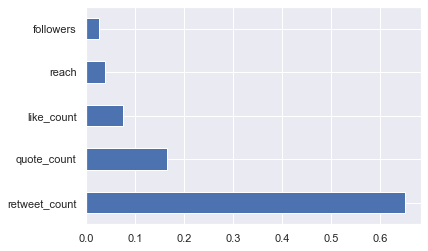

In [207]:
#TREE BASED CLASSIFIERS
model = ExtraTreesClassifier()
model.fit(X_train_num_scaled, y_train)
print(model.feature_importances_)  #use inbuilt class feature_importances of tree based classifiers

feat_importances = pd.Series(model.feature_importances_, index=X_train_num_scaled.columns)
feat_importances.nlargest(5).plot(kind='barh')
plt.show()

In [208]:
feat_importances.nlargest(5).index

Index(['retweet_count', 'quote_count', 'like_count', 'reach', 'followers'], dtype='object')

In [209]:
num_feat_to_keep['Tree Based Classifiers'] = 'Discard'

for var in feat_importances.nlargest(5).index:
    num_feat_to_keep.loc[var, 'Tree Based Classifiers'] = 'Keep'

### ENTROPY / GINI IMPORTANCE

In [210]:
#ENTROPY / GINI IMPORTANCE
gini_importance = DecisionTreeClassifier().fit(X_train_num_scaled, y_train).feature_importances_
entropy_importance = DecisionTreeClassifier(criterion='entropy').fit(X_train_num_scaled, y_train).feature_importances_

<AxesSubplot:xlabel='Value', ylabel='Col'>

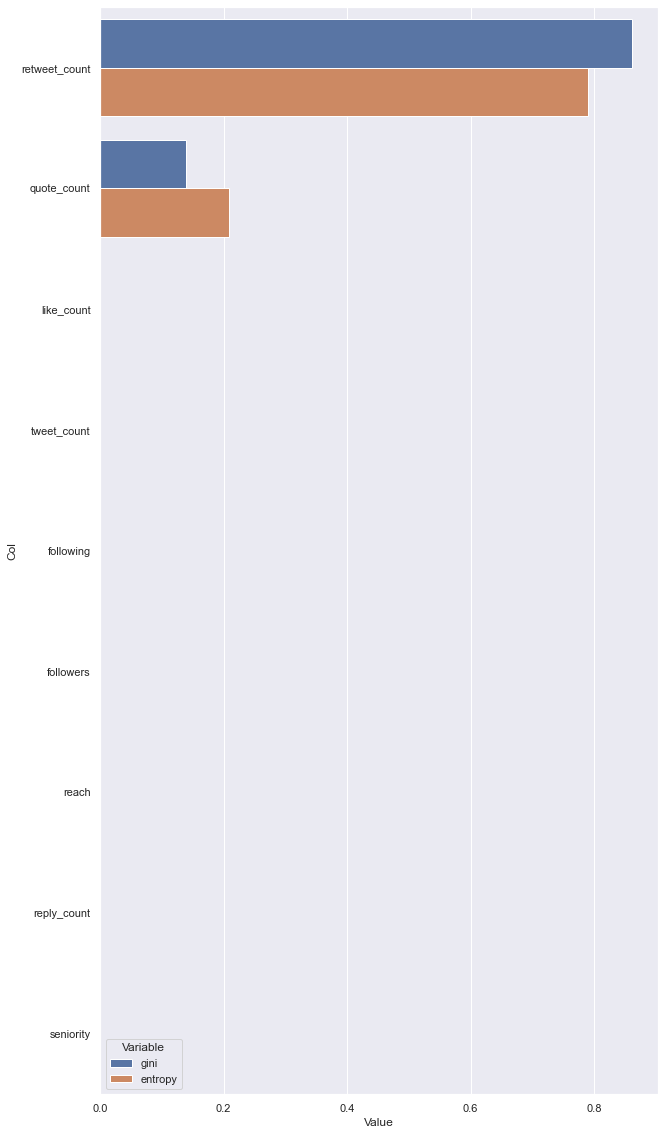

In [211]:
zippy = pd.DataFrame(zip(gini_importance, entropy_importance), columns=['gini', 'entropy'])
zippy['col'] = X_train_num_scaled.columns
tidy = zippy.melt(id_vars='col').rename(columns=str.title)
tidy.sort_values(['Value'], ascending=False, inplace=True)

plt.figure(figsize=(10, 20))
sns.barplot(y='Col', x='Value', hue='Variable', data=tidy)

In [212]:
zippy = zippy.set_index('col')
num_feat_to_keep['Gini Importance'] = 'Discard'

for var in zippy['gini'].nlargest(5).index:
    num_feat_to_keep.loc[var, 'Gini Importance'] = 'Keep'

### Forward Selection

In [213]:
sys.modules['sklearn.externals.joblib'] = joblib
sfs = Sfs(LogisticRegression(),
          k_features=5,
          forward=True,
          floating=False,
          scoring='r2',
          cv=5)
sfs.fit(X_train_num_scaled, y_train)
sfs.k_feature_names_

('like_count', 'retweet_count', 'quote_count', 'reach', 'followers')

In [214]:
num_feat_to_keep['Sequential Feature Selection'] = 'Discard'

for var in sfs.k_feature_names_:
    num_feat_to_keep.loc[var, 'Sequential Feature Selection'] = 'Keep'

### Final Selected Variables

In [215]:
num_feat_to_keep['Discard Nr'] = num_feat_to_keep.apply(lambda x: x.str.findall('Discard').str.len()).sum(
    axis=1).astype(int)
num_feat_to_keep

,RFE,Ridge Regression,ANOVA,Tree Based Classifiers,Gini Importance,Sequential Feature Selection,Discard Nr
like_count,Keep,Discard,Keep,Keep,Keep,Keep,1
retweet_count,Keep,Discard,Keep,Keep,Keep,Keep,1
quote_count,Keep,Keep,Keep,Keep,Keep,Keep,0
reply_count,Discard,Keep,Keep,Discard,Keep,Discard,3
reach,Keep,Keep,Keep,Keep,Keep,Keep,0
followers,Keep,Discard,Keep,Keep,Discard,Keep,2
following,Discard,Keep,Keep,Discard,Discard,Discard,4
tweet_count,Discard,Discard,Keep,Discard,Discard,Discard,5
seniority,Discard,Keep,Keep,Discard,Discard,Discard,4


In [216]:
cat_feat_to_keep

,Chi square
sentiment_enc,Keep
verified_enc,Keep
day_of_week_enc,Discard
day_phase_enc,Keep
month_enc,Keep


In [217]:
variables_to_keep = ['like_count', 'reply_count', 'reach', 'followers', 'month_enc', 'verified_enc', 'day_phase_enc']

In [218]:
X_train_scaled = X_train_scaled[variables_to_keep]
X_val_scaled = X_val_scaled[variables_to_keep]
df_2020['popularity'].value_counts(normalize=True)

0    0.808243
1    0.191757
Name: popularity, dtype: float64

## Balacing the dataset

#### Random Under Sampling method

In [20]:
# summarize class distribution
print("Before under sampling: ", Counter(y_train))
# define undersampling strategy
under_sample = RandomUnderSampler(sampling_strategy='majority')
# fit and apply the transform
X_train_under, y_train_under = under_sample.fit_resample(X_train_scaled, y_train)
# summarize class distribution
print("After under sampling: ", Counter(y_train_under))

Before under sampling:  Counter({0: 46564, 1: 10712})
After under sampling:  Counter({0: 10712, 1: 10712})


#### SMOTE method

In [21]:
# summarize class distribution
print("Before over sampling: ", Counter(y_train))
over_sample = SMOTE(random_state=seed)
X_train_over, y_train_over = over_sample.fit_resample(X_train_scaled, y_train)
# summarize class distribution
print("After over sampling: ", Counter(y_train_over))

Before over sampling:  Counter({0: 46564, 1: 10712})
After over sampling:  Counter({1: 46564, 0: 46564})


## Models

### Defining the algorithms

In [22]:
models = [('LR', LogisticRegression(solver='lbfgs')), ('LDA', LinearDiscriminantAnalysis()),
          ('KNN', KNeighborsClassifier()), ('CART', DecisionTreeClassifier()), ('NB', GaussianNB())]
          #('SVM', SVC(gamma='scale'))]

In [23]:
def algorithm_comparison(title):
    fig = plt.figure()
    fig.suptitle(title)
    ax = fig.add_subplot(111)
    plt.boxplot(results)
    ax.set_xticklabels(names)
    plt.figure(figsize=(16, 9))
    plt.show()

#### Algorithm benchmark with Under Sampling

In [24]:
results = []
names = []
for name, model in models:
	kfold = KFold(n_splits=num_folds)
	cv_results = cross_val_score(model, X_train_under, y_train_under, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)

/Users/migueloliveira/opt/anaconda3/envs/pythonProject2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/migueloliveira/opt/anaconda3/envs/pythonProject2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    htt

LR: 0.718595 (0.204990)
LDA: 0.205973 (0.061780)
KNN: 0.491442 (0.085558)
CART: 1.000000 (0.000000)
NB: 0.995566 (0.004937)


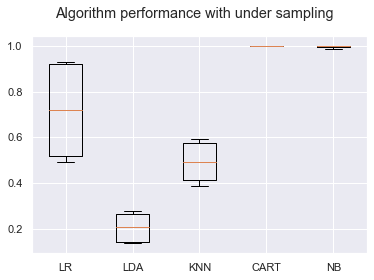

<Figure size 1152x648 with 0 Axes>

In [25]:
algorithm_comparison('Algorithm performance with under sampling')

#### Algorithm benchmark with Over Sampling

In [26]:
results = []
names = []
for name, model in models:
	kfold = KFold(n_splits=num_folds)
	cv_results = cross_val_score(model, X_train_over, y_train_over, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)

/Users/migueloliveira/opt/anaconda3/envs/pythonProject2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/migueloliveira/opt/anaconda3/envs/pythonProject2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    htt

LR: 0.821189 (0.118207)
LDA: 0.382651 (0.177217)
KNN: 0.781175 (0.092362)
CART: 1.000000 (0.000000)
NB: 0.995522 (0.003435)


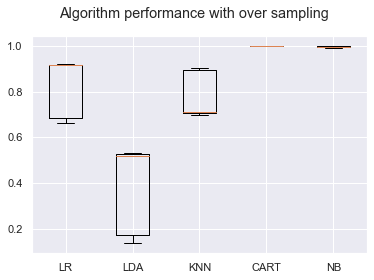

<Figure size 1152x648 with 0 Axes>

In [27]:
algorithm_comparison('Algorithm performance with over sampling')

### Ensemble methods

#### Algorithm benchmark with Under Sampling

In [227]:
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

ensembles = [('AB', AdaBoostClassifier()), ('GBM', GradientBoostingClassifier()),
             ('RFC', RandomForestClassifier(n_estimators=100)), ('ET', ExtraTreesClassifier())]
results = []
names = []
for name, model in ensembles:
    kfold = KFold(n_splits=num_folds)
    cv_results = cross_val_score(model, X_train_under, y_train_under, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

AB: 0.621616 (0.176486)
GBM: 0.615633 (0.175001)
RFC: 0.601050 (0.160219)
ET: 0.579823 (0.159675)


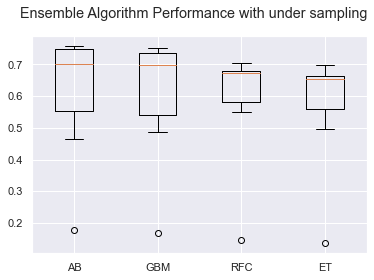

<Figure size 1152x648 with 0 Axes>

In [228]:
algorithm_comparison('Ensemble Algorithm Performance with under sampling')

#### Algorithm benchmark with Over Sampling

In [229]:
ensembles = [('AB', AdaBoostClassifier()), ('GBM', GradientBoostingClassifier()),
             ('RFC', RandomForestClassifier(n_estimators=100)), ('ET', ExtraTreesClassifier())]
results = []
names = []
for name, model in ensembles:
    kfold = KFold(n_splits=num_folds)
    cv_results = cross_val_score(model, X_train_over, y_train_over, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

AB: 0.721831 (0.036409)
GBM: 0.737258 (0.041929)
RFC: 0.776668 (0.061669)
ET: 0.763040 (0.053038)


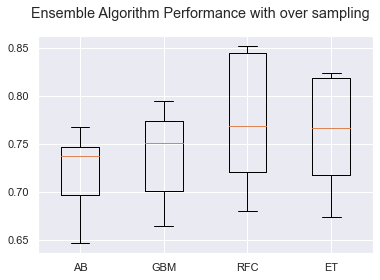

<Figure size 1152x648 with 0 Axes>

In [230]:
algorithm_comparison('Ensemble Algorithm Performance with over sampling')

#### Tuning the best ensemble model (RFC)

In [231]:
# param_grid = dict(n_estimators=numpy.array([50, 100, 150, 200, 250, 300, 350, 400]))
#param_grid = dict(n_estimators=numpy.array([50, 200, 300, 400]))
#model = RandomForestClassifier(random_state=seed)
#kfold = KFold(n_splits=num_folds)
#grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
#grid_result = grid.fit(X_train_over, y_train_over)

#print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
#means = grid_result.cv_results_['mean_test_score']
#stds = grid_result.cv_results_['std_test_score']
#params = grid_result.cv_results_['params']
#for mean, stdev, param in zip(means, stds, params):
#    print("%f (%f) with: %r" % (mean, stdev, param))

#### Tuning Gradient Boosting Classifier

In [232]:
param_grid = dict(n_estimators=numpy.array([20, 30, 40, 50, 60, 70, 80]))
model = GradientBoostingClassifier(random_state=seed, learning_rate=0.1, min_samples_split=500,min_samples_leaf=50,max_depth=8,max_features='sqrt',subsample=0.8)
kfold = KFold(n_splits=num_folds)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train_scaled, y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.869788 using {'n_estimators': 80}
0.865685 (0.007371) with: {'n_estimators': 20}
0.867588 (0.006911) with: {'n_estimators': 30}
0.868077 (0.006896) with: {'n_estimators': 40}
0.868758 (0.006573) with: {'n_estimators': 50}
0.869229 (0.006666) with: {'n_estimators': 60}
0.869631 (0.006891) with: {'n_estimators': 70}
0.869788 (0.006355) with: {'n_estimators': 80}


In [233]:
param_grid2 = {'max_depth':[9], 'min_samples_split':range(1000,1601,200)}
model = GradientBoostingClassifier(random_state=seed, learning_rate=0.1, n_estimators=40, max_features='sqrt',subsample=0.8)
kfold = KFold(n_splits=num_folds)
grid = GridSearchCV(estimator=model, param_grid=param_grid2, scoring='roc_auc', cv=kfold)
grid_result = grid.fit(X_train_scaled, y_train)

#0.857884 : acc
# 0.850

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.863621 using {'max_depth': 9, 'min_samples_split': 1000}
0.863621 (0.007518) with: {'max_depth': 9, 'min_samples_split': 1000}
0.863272 (0.007071) with: {'max_depth': 9, 'min_samples_split': 1200}
0.862908 (0.007474) with: {'max_depth': 9, 'min_samples_split': 1400}
0.863370 (0.006842) with: {'max_depth': 9, 'min_samples_split': 1600}


In [234]:
param_grid3 = {'min_samples_split':range(1000,1600,200), 'min_samples_leaf':range(30,71,10)}
model = GradientBoostingClassifier(random_state=seed, learning_rate=0.1, n_estimators=40, max_depth=9, max_features='sqrt',subsample=0.8)
kfold = KFold(n_splits=num_folds)
grid = GridSearchCV(estimator=model, param_grid=param_grid3, scoring='roc_auc', cv=kfold)
grid_result = grid.fit(X_train_scaled, y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.863068 using {'min_samples_leaf': 40, 'min_samples_split': 1400}
0.863008 (0.007501) with: {'min_samples_leaf': 30, 'min_samples_split': 1000}
0.862933 (0.007172) with: {'min_samples_leaf': 30, 'min_samples_split': 1200}
0.863056 (0.007733) with: {'min_samples_leaf': 30, 'min_samples_split': 1400}
0.862983 (0.007285) with: {'min_samples_leaf': 40, 'min_samples_split': 1000}
0.863034 (0.007139) with: {'min_samples_leaf': 40, 'min_samples_split': 1200}
0.863068 (0.007466) with: {'min_samples_leaf': 40, 'min_samples_split': 1400}
0.862971 (0.007253) with: {'min_samples_leaf': 50, 'min_samples_split': 1000}
0.862251 (0.007356) with: {'min_samples_leaf': 50, 'min_samples_split': 1200}
0.862741 (0.007244) with: {'min_samples_leaf': 50, 'min_samples_split': 1400}
0.862815 (0.007295) with: {'min_samples_leaf': 60, 'min_samples_split': 1000}
0.862485 (0.007453) with: {'min_samples_leaf': 60, 'min_samples_split': 1200}
0.862788 (0.007449) with: {'min_samples_leaf': 60, 'min_samples_split

In [235]:
param_grid4 = {'max_features':range(7,20,2)}
model = GradientBoostingClassifier(learning_rate=0.1, n_estimators=40, max_depth=9, min_samples_split=1200, min_samples_leaf=40, subsample=0.8, random_state=10)
kfold = KFold(n_splits=num_folds)
grid = GridSearchCV(estimator=model, param_grid=param_grid4, scoring='roc_auc', cv=kfold)
grid_result = grid.fit(X_train_scaled, y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

/Users/migueloliveira/opt/anaconda3/envs/pythonProject2/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning:


60 fits failed out of a total of 70.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/migueloliveira/opt/anaconda3/envs/pythonProject2/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/migueloliveira/opt/anaconda3/envs/pythonProject2/lib/python3.10/site-packages/sklearn/ensemble/_gb.py", line 586, in fit
    n_stages = self._fit_stages(
  File "/Users/migueloliveira/opt/anaconda3/envs/pythonP

Best: 0.864883 using {'max_features': 7}
0.864883 (0.007275) with: {'max_features': 7}
nan (nan) with: {'max_features': 9}
nan (nan) with: {'max_features': 11}
nan (nan) with: {'max_features': 13}
nan (nan) with: {'max_features': 15}
nan (nan) with: {'max_features': 17}
nan (nan) with: {'max_features': 19}


In [236]:
param_grid5 = {'subsample':[0.6,0.7,0.75,0.8,0.85,0.9]}
model = GradientBoostingClassifier(learning_rate=0.1, n_estimators=40, max_depth=9, min_samples_split=1200, min_samples_leaf=40, subsample=0.8, max_features=7, random_state=seed)
kfold = KFold(n_splits=num_folds)
grid = GridSearchCV(estimator=model, param_grid=param_grid5, scoring='roc_auc', cv=kfold)
grid_result = grid.fit(X_train_scaled, y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.865577 using {'subsample': 0.8}
0.865066 (0.007983) with: {'subsample': 0.6}
0.865264 (0.007367) with: {'subsample': 0.7}
0.865130 (0.007357) with: {'subsample': 0.75}
0.865577 (0.007680) with: {'subsample': 0.8}
0.865106 (0.007491) with: {'subsample': 0.85}
0.865394 (0.007697) with: {'subsample': 0.9}


#### The final values were:

min_samples_split: 1200
min_samples_leaf: 40
max_depth: 9
max_features: 7
subsample: 0.85

New test with half the learning rate and double the nº of trees (estimators)

In [28]:
model = GradientBoostingClassifier(learning_rate=0.05, n_estimators=80, max_depth=9, min_samples_split=1200, min_samples_leaf=40, subsample=0.85, max_features=7, random_state=seed)

model.fit(X_train_scaled, y_train)
predictions = model.predict(X_val_scaled)
print(accuracy_score(y_validation, predictions))
print(confusion_matrix(y_validation, predictions))
print(classification_report(y_validation, predictions))

0.8886319932359125
[[108752      0]
 [ 14884  10011]]
              precision    recall  f1-score   support

           0       0.88      1.00      0.94    108752
           1       1.00      0.40      0.57     24895

    accuracy                           0.89    133647
   macro avg       0.94      0.70      0.75    133647
weighted avg       0.90      0.89      0.87    133647



In [238]:
model = GradientBoostingClassifier(learning_rate=0.01, n_estimators=400, max_depth=9, min_samples_split=1200, min_samples_leaf=40, subsample=0.85, max_features=7, random_state=seed)

model.fit(X_train_scaled, y_train)
predictions = model.predict(X_val_scaled)
print(accuracy_score(y_validation, predictions))
print(confusion_matrix(y_validation, predictions))
print(classification_report(y_validation, predictions))

0.1809767521904719
[[    34 109454]
 [     6  24153]]
              precision    recall  f1-score   support

           0       0.85      0.00      0.00    109488
           1       0.18      1.00      0.31     24159

    accuracy                           0.18    133647
   macro avg       0.52      0.50      0.15    133647
weighted avg       0.73      0.18      0.06    133647



In [239]:
model = GradientBoostingClassifier(learning_rate=0.005, n_estimators=800, max_depth=9, min_samples_split=1200, min_samples_leaf=40, subsample=0.85, max_features=7, random_state=seed)

model.fit(X_train_scaled, y_train)
predictions = model.predict(X_val_scaled)
print(accuracy_score(y_validation, predictions))
print(confusion_matrix(y_validation, predictions))
print(classification_report(y_validation, predictions))

0.18089444581621736
[[    22 109466]
 [     5  24154]]
              precision    recall  f1-score   support

           0       0.81      0.00      0.00    109488
           1       0.18      1.00      0.31     24159

    accuracy                           0.18    133647
   macro avg       0.50      0.50      0.15    133647
weighted avg       0.70      0.18      0.06    133647



In [31]:
def run_tuned_random_forest(x_train, x_test, y_train, y_test):
    model = RandomForestClassifier(random_state=seed, n_estimators=100)
    model.fit(x_train, y_train)
    predictions = model.predict(x_test)
    print(accuracy_score(y_test, predictions))
    print(confusion_matrix(y_test, predictions))
    print(classification_report(y_test, predictions))
    joblib.dump(model, '../../data/models/popularity.joblib')

In [32]:
run_tuned_random_forest(X_train_over, X_val_scaled, y_train_over, y_validation)

0.197258449497557
[[  1660 107092]
 [   192  24703]]
              precision    recall  f1-score   support

           0       0.90      0.02      0.03    108752
           1       0.19      0.99      0.32     24895

    accuracy                           0.20    133647
   macro avg       0.54      0.50      0.17    133647
weighted avg       0.76      0.20      0.08    133647



## Testing the created model to predict 2021 tweets popularity

In [33]:
test_2021 = df_2021[variables_to_keep]
target = df_2021['popularity']

NameError: name 'variables_to_keep' is not defined

In [34]:
popularity_model = joblib.load('../../data/models/popularity.joblib')
predictions = popularity_model.predict(test_2021)
print(accuracy_score(target, predictions))
print(confusion_matrix(target, predictions))
print(classification_report(target, predictions))

NameError: name 'test_2021' is not defined

In [ ]:
X_train_over['']